In [1]:
## Get new prepocess format running

In [2]:
from functions import *

In [3]:
models,data, errors=find_data(version='d_march1')

In [4]:
print(data,errors)

['Realisierter_Stromverbrauch_202402200600_202403020559_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202402230600_202403050559_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202402240600_202403060559_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202402250600_202403070559_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202402260600_202403080559_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202402270600_202403090559_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202402280600_202403100559_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202402290600_202403110459_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202403010600_202403120459_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202403020600_202403130459_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202403030600_202403140459_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202403040600_202403150459_Viertelstunde.csv', 'Realisierter_Stromverbrauch_202403050600_202403160459_Viertelstunde.csv', 'Realisierter_Stromverbr

In [5]:
new_real=pd.read_csv(data[-1],delimiter=';')
old_real=pd.read_csv(data[-10],delimiter=';')

In [6]:
print(data[-1],data[-10])
print(new_real.describe())
print(old_real.describe())
print(new_real.columns)
print(old_real.columns)
print(old_real.iloc[70:80,:])
print(new_real.iloc[70:80,:])

Realisierter_Stromverbrauch_202410190600_202410300500_Viertelstunde.csv Realisierter_Stromverbrauch_202403240500_202404040559_Viertelstunde.csv
               Datum von         Datum bis  \
count               1056              1056   
unique              1052              1052   
top     27.10.2024 02:30  27.10.2024 02:45   
freq                   2                 2   

       Gesamt (Netzlast) [MWh] Originalauflösungen  \
count                                         1056   
unique                                         913   
top                                              -   
freq                                           128   

       Residuallast [MWh] Originalauflösungen  \
count                                    1056   
unique                                    913   
top                                         -   
freq                                      128   

       Pumpspeicher [MWh] Originalauflösungen  
count                                    1056  
unique      

In [7]:
def prepare_input2(df,pump=False,end=False,bad_cut=0.9,zero_time=(2015,1,1,0,0),str_convert=True,version='y_fraction1',new_level=0):
    #zero time of model can change later
    zero=datetime(zero_time[0],zero_time[1],zero_time[2],zero_time[3],zero_time[4])
    if new_level==0:
        dic1={'Datum':'Date','Uhrzeit':'Time','Gesamt (Netzlast)[MWh]':'total_power','Residuallast[MWh]':'residual_power','Pumpspeicher[MWh]':'pump_storage'}
        df.rename(columns=dic1,inplace=True)
    #new column names
    elif new_level==1:
        dic2={'Datum':'Date','Anfang':'Time','Gesamt (Netzlast) [MWh] Originalauflösungen':'total_power','Residuallast [MWh] Originalauflösungen':'residual_power','Pumpspeicher [MWh] Originalauflösungen':'pump_storage'}
        df.rename(columns=dic2,inplace=True)   
    elif new_level==2:
        dic3={'Datum von':'date_time','Datum bis':'date_time_end','Gesamt (Netzlast) [MWh] Originalauflösungen':'total_power','Residuallast [MWh] Originalauflösungen':'residual_power','Pumpspeicher [MWh] Originalauflösungen':'pump_storage'}
        df.rename(columns=dic3,inplace=True)     
    #drop columns
    if end==True and new_level<2:
        df.drop(['Ende'], axis=1, inplace=True)
    if end==True and new_level==2:
        df.drop(['date_time_end'], axis=1, inplace=True)        
    #cpnvert german float to english 
    if str_convert==True:
        df['residual_power'] =df['residual_power'].astype(str)
        df['residual_power'] = df['residual_power'].str.replace('.','')
        df['residual_power'] = df['residual_power'].str.replace('-','0')
        df['residual_power'] = df['residual_power'].str.replace(',','.').astype(float)/1000.
        df['total_power'] =df['total_power'].astype(str)
        df['total_power'] = df['total_power'].str.replace('.','')
        df['total_power'] = df['total_power'].str.replace('-','0')    
        df['total_power'] = df['total_power'].str.replace(',','.').astype(float)/1000.
        if pump==True:
            df['pump_storage'] =df['pump_storage'].astype(str)
            df['pump_storage'] = df['pump_storage'].str.replace('.','')
            df['pump_storage'] = df['pump_storage'].str.replace(',','.').astype(float)/1000.       
    #old not combined date and time         
    if new_level<2:        
        df['date_time']=pd.to_datetime(df['Date'] + '.' + df['Time'], format='%d.%m.%Y.%H:%M')
    #new is combined     
    elif new_level==2:
        df['date_time']=pd.to_datetime(df['date_time'], format='%d.%m.%Y %H:%M')
    delta=str(df.loc[0,'date_time']-zero)
    #deltam=time.strftime(delta,'%M')
    days=delta.split(' days ')
    hour=days[1].split(':')
    #difference in fraction of days
    diff_frac=float(days[0])+float(hour[0])/24+float(hour[1])/24/60
    time1=np.zeros((df.shape[0],5))
    for i in range(df.shape[0]):
        time1[i,0]=diff_frac+i/4/24
        time1[i,1]=time1[i,0]%1
        time1[i,2]=(time1[i,0]%7)/7
        time1[i,3]=(time1[i,0]%365.25)/365.25
        time1[i,4]=i/4/24/365.25      
    df['frac_day']=time1[:,1]
    df['frac_week']=time1[:,2]
    df['frac_year']=time1[:,3]
    #works at least for full days, later more checks 
    #helper parameter used below
    df['year']=df.date_time.dt.year.astype(int)
    df['month']=df.date_time.dt.month.astype(int)
    #days from easter of this year
    df['delta_easter']=0
    #days from first march of the year, gest holidayts right given leap years
    df['delta_march']=0
    #works at least for full days, later more checks 
    for i in range(df.shape[0]):
        df['delta_easter'].iloc[i]=(df['date_time'].iloc[i]-pd.to_datetime(easter(df.year.iloc[i]))).days
        if df.month.iloc[i]<2.5:
            df['delta_march'].iloc[i]=(df['date_time'].iloc[i]-datetime(df['year'].iloc[i]-1,3,1)).days
        else:
            df['delta_march'].iloc[i]=(df['date_time'].iloc[i]-datetime(df['year'].iloc[i],3,1)).days            
    #exclude what is zero at the end
    c=0
    while df.loc[df.shape[0]+c-1,'total_power']==0:
        c-=1
    #interpolate linear bad value (only exatcly 0 for now) which are not at the beginning or end 
    for i in range(1,df.shape[0]+c-2):
        if df.loc[i,'total_power']==0:
            df.loc[i,'total_power']=(df.loc[i-1,'total_power']+df.loc[i+1,'total_power'])/2    
    #return of the the needed columns in the right order, and dleta when last is likely bad
    delta=0                   
    if df.loc[df.shape[0]+c-1,'total_power']/df.loc[df.shape[0]+c-2,'total_power']<bad_cut:
        delta=-1
    #return needed output, order matters    
    if version=='y_fraction1':    
        return df.loc[:df.shape[0]+c-1+delta,['total_power','frac_day', 'frac_week', 'frac_year','date_time']]
    elif version=='d_easter1':    
        return df.loc[:df.shape[0]+c-1+delta,['frac_day','frac_week','delta_easter','total_power','date_time']] 
    elif version=='d_march1':    
        return df.loc[:df.shape[0]+c-1+delta,['frac_day','frac_week','delta_march','total_power','date_time']]    

In [8]:
new_in=prepare_input2(new_real,new_level=2,str_convert=True,version='d_march1')

/tmp/ipykernel_13650/364788480.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/tmp/ipykernel_13650/364788480.py:26: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/tmp/ipykernel_13650/364788480.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_easter'].iloc[i]=(df['date_time'].iloc[i]-pd.to_datetime(easter(df.year.iloc[i]))).days
/tmp/ipykernel_13650/3647

In [9]:
old_in=prepare_input2(old_real,new_level=1,version='d_easter1',str_convert=True)
print(old_in.describe())

/tmp/ipykernel_13650/364788480.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/tmp/ipykernel_13650/364788480.py:26: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/tmp/ipykernel_13650/364788480.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_easter'].iloc[i]=(df['date_time'].iloc[i]-pd.to_datetime(easter(df.year.iloc[i]))).days
/tmp/ipykernel_13650/3647

          frac_day    frac_week  delta_easter   total_power
count  1002.000000  1002.000000   1002.000000  1.002000e+03
mean      0.491735     0.566398     -2.057884  1.147130e+01
std       0.284243     0.267877      3.046533  3.979578e+00
min       0.000000     0.000000     -7.000000  4.336107e-25
25%       0.250000     0.372396     -5.000000  1.056250e+01
50%       0.489583     0.601190     -2.000000  1.195575e+01
75%       0.729167     0.787202      1.000000  1.445394e+01
max       0.989583     0.998512      3.000000  1.655950e+01


In [10]:
print(new_in.describe())

          frac_day    frac_week  delta_march   total_power
count  1018.000000  1018.000000  1018.000000  1.018000e+03
mean      0.497759     0.526062   237.041257  1.211572e+01
std       0.283786     0.252936     3.063450  4.278646e+00
min       0.000000     0.000000   232.000000  2.810071e-26
25%       0.260417     0.349702   234.000000  1.072612e+01
50%       0.500000     0.538690   237.000000  1.290575e+01
75%       0.739583     0.727679   240.000000  1.525969e+01
max       0.989583     0.998512   242.000000  1.687150e+01


In [11]:
#now hidden parameters for march
#parameter, version of models, whetehr process is printed, whether error is used in Figure
def pipeline_v3(version='d_march1',silent=True,plot_error=False,mode='quadratic1',new_level=2):
    #get model and data file lists
    if version=='y_fraction1':
        models,data=find_data(version=version)
        #create dummy errors to simplyfy prediction below
        errors=np.zeros((3,len(models)))
        #create non zero error to avoid error problem
        errors[1]=1.
    elif version=='d_easter1':
        models,data,errors=find_data(version=version)   
    elif version=='d_march1':
        models,data,errors=find_data(version=version)         
    #also error/offset file if exist    
    #last in list is newest 
    new_real=pd.read_csv(data[-1],delimiter=';')
    power_newest=prepare_input2(new_real,new_level=new_level,version=version,str_convert=True)
    #apply prediction
    prediction_newest,y,mo,d,h,mi=predict_from_now(power_newest.loc[power_newest.shape[0]-3:power_newest.shape[0],:],models[:],errors,silent=silent,version=version)
    #clean prediction
    prediction_newest=clean_prediction(prediction_newest,y,mo,d,h,mi,silent=silent,mode=mode,version=version)
    #plot prediction
    plot_prediction(power_newest.iloc[:,:],prediction_newest,plot_error=plot_error)

In [12]:
#now hidden parameters for d_easter1 model 
#parameter, version of models, whetehr process is printed, whether error is used in Figure
def pipeline_v3b(version='d_easter1',silent=True,plot_error=False,mode='quadratic1',new_level=2):
    #get model and data file lists
    if version=='y_fraction1':
        models,data=find_data(version=version)
        #create dummy errors to simplyfy prediction below
        errors=np.zeros((3,len(models)))
        #create non zero error to avoid error problem
        errors[1]=1.
    elif version=='d_easter1':
        models,data,errors=find_data(version=version)   
    elif version=='d_march1':
        models,data,errors=find_data(version=version)         
    #also error/offset file if exist    
    #last in list is newest 
    new_real=pd.read_csv(data[-1],delimiter=';')
    power_newest=prepare_input2(new_real,new_level=new_level,version=version,str_convert=True)
    #apply prediction
    prediction_newest,y,mo,d,h,mi=predict_from_now(power_newest.loc[power_newest.shape[0]-3:power_newest.shape[0],:],models[:],errors,silent=silent,version=version)
    #clean prediction
    prediction_newest=clean_prediction(prediction_newest,y,mo,d,h,mi,silent=silent,mode=mode,version=version)
    #plot prediction
    plot_prediction(power_newest.iloc[:,:],prediction_newest,plot_error=plot_error)

/tmp/ipykernel_13650/364788480.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/tmp/ipykernel_13650/364788480.py:26: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/tmp/ipykernel_13650/364788480.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_easter'].iloc[i]=(df['date_time'].iloc[i]-pd.to_datetime(easter(df.year.iloc[i]))).days
/tmp/ipykernel_13650/3647

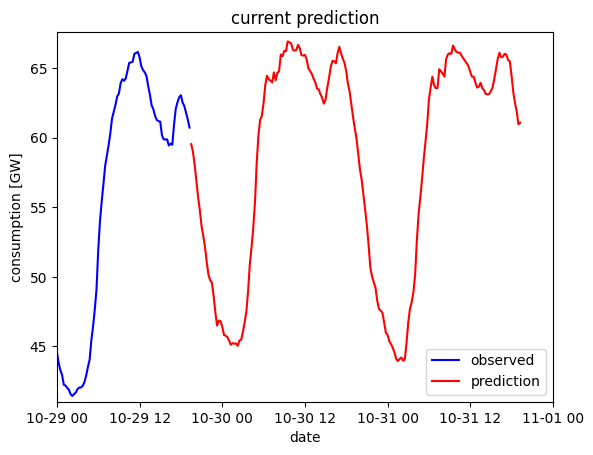

In [13]:
pipeline_v3b()

/tmp/ipykernel_13650/364788480.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/tmp/ipykernel_13650/364788480.py:26: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/tmp/ipykernel_13650/364788480.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_easter'].iloc[i]=(df['date_time'].iloc[i]-pd.to_datetime(easter(df.year.iloc[i]))).days
/tmp/ipykernel_13650/3647

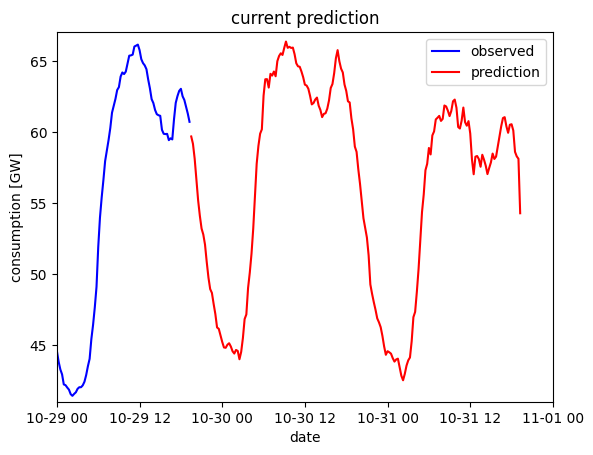

In [14]:
pipeline_v3()

## Checking the pipeline in different versions

/home/tobias/ml-testing/energy/energy-timeseries/functions.py:876: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:880: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:919: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_easter'].iloc[i]=(df['date

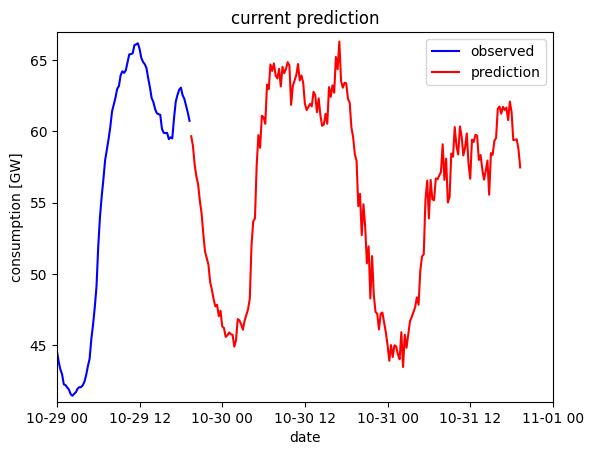

In [15]:
pipeline(new_level=2,version='y_fraction1')

/home/tobias/ml-testing/energy/energy-timeseries/functions.py:876: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:880: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:919: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_easter'].iloc[i]=(df['date

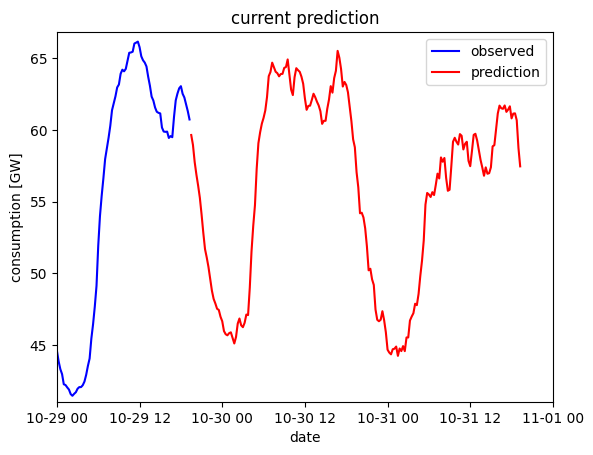

In [16]:
pipeline(new_level=2,version='y_fraction1',mode='quadratic1')

/home/tobias/ml-testing/energy/energy-timeseries/functions.py:876: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:880: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:919: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_easter'].iloc[i]=(df['date

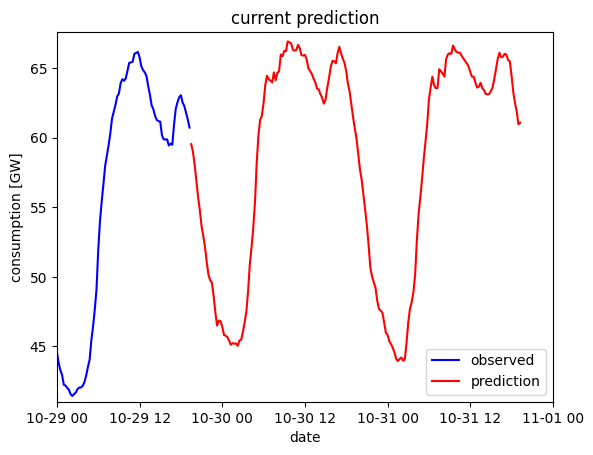

In [17]:
pipeline(new_level=2,version='d_easter1',mode='quadratic1')

/home/tobias/ml-testing/energy/energy-timeseries/functions.py:525: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:528: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:566: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_easter'].iloc[i]=(df['date

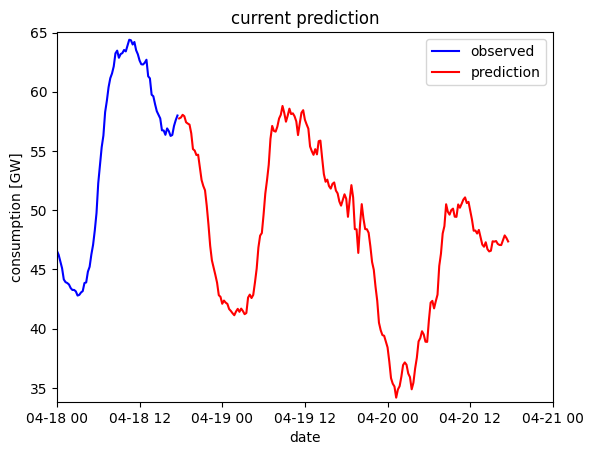

In [13]:
pipeline(new_level=2,version='d_march1',mode='quadratic1')

Look good in general.
Now the versions. 

/tmp/ipykernel_13650/364788480.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/tmp/ipykernel_13650/364788480.py:26: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/tmp/ipykernel_13650/364788480.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_easter'].iloc[i]=(df['date_time'].iloc[i]-pd.to_datetime(easter(df.year.iloc[i]))).days
/tmp/ipykernel_13650/3647

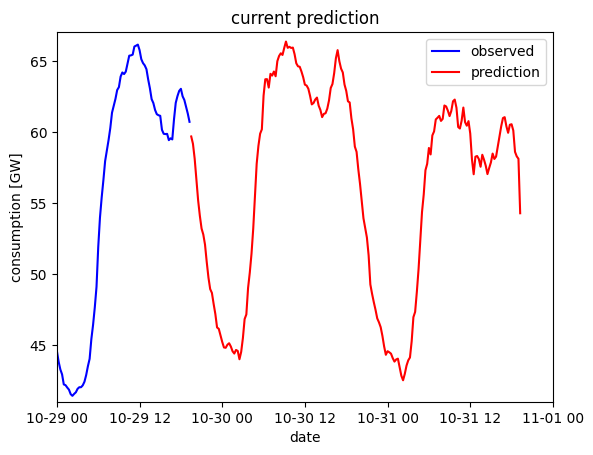

In [18]:
pipeline_v3()

/tmp/ipykernel_13650/364788480.py:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/tmp/ipykernel_13650/364788480.py:26: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/tmp/ipykernel_13650/364788480.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_easter'].iloc[i]=(df['date_time'].iloc[i]-pd.to_datetime(easter(df.year.iloc[i]))).days
/tmp/ipykernel_13650/3647

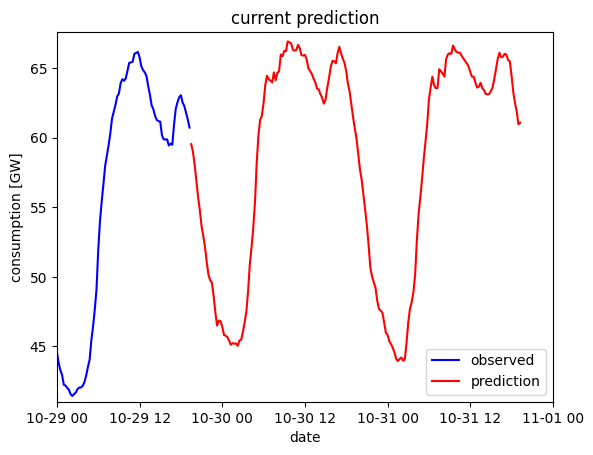

In [19]:
pipeline_v3b()

Identical as above as it should be. 